In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from Farm_Evaluator_Vec import *

In [3]:
'''preprocessing to compute AEP'''

# Turbine Specifications.
# -**-SHOULD NOT BE MODIFIED-**-
turb_specs    =  {   
                     'Name': 'Anon Name',
                     'Vendor': 'Anon Vendor',
                     'Type': 'Anon Type',
                     'Dia (m)': 100,
                     'Rotor Area (m2)': 7853,
                     'Hub Height (m)': 100,
                     'Cut-in Wind Speed (m/s)': 3.5,
                     'Cut-out Wind Speed (m/s)': 25,
                     'Rated Wind Speed (m/s)': 15,
                     'Rated Power (MW)': 3
                 }
turb_diam      =  turb_specs['Dia (m)']
turb_rad       =  turb_diam/2 

# turb_coords   =  getTurbLoc(r'..\Shell_Hackathon Dataset\turbine_loc_test.csv')
# power_curve   =  loadPowerCurve('..\Shell_Hackathon Dataset\power_curve.csv')
# wind_inst_freq =  binWindResourceData(r'..\Shell_Hackathon Dataset\Wind Data\wind_data_2007.csv')   
power_curve   =  loadPowerCurve('./power_curve.csv')
wind_inst_freq =  binWindResourceData('./wind_data_2007.csv')   

n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t = preProcessing(power_curve)


def AEP_simp(turb_coords,print_=0):
#     checkConstraints(turb_coords, turb_diam)

    #print('Calculating AEP......')        
    AEP = getAEP(turb_rad, turb_coords, power_curve, wind_inst_freq, 
              n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t) 
    if print_:
        print('Total power produced by the wind farm is: ', "%.12f"%(AEP), 'GWh')
    return AEP

In [4]:
def check_inc_violation(pts,point):
    '''check if adding new point will casue an violation'''
    x,y = point
    if x<50 or x>3950 or y<50 or y>3950:
        return 1
    for x0,y0 in pts:
        if (x0-x)**2 + (y0-y)**2 < 400**2:
            return 1
    return 0

def to_csv(arr,filename='turbinesrand.csv'):
    '''convert the locations into a csv file'''
    df = pd.DataFrame(arr)
    df = df.rename(columns = {0:'x',1:'y'})
    df.to_csv(filename,index=False)


def get_random_turb_locations():
    '''generate a random configuration that does not violate the constraints'''
    locs = []
    locs.append(np.random.randint(size=2,low=50,high=3950))
    for i in range(49):
        while True:
            point = np.random.randint(size=2,low=50,high=3950)
            if not check_inc_violation(locs,point):
                locs.append(point)
                break
    return np.array(locs)
    
def plot_constraint_violations(pts):
    for i in range(len(pts)):
        x0,y0 = pts[i]
        if x0<50 or x0>3950 or y0<50 or y0>3950:
            #plt.scatter(x0,y0,'r')
            print(x0,y0)
        for j in range(i+1,len(pts)):
            x1,y1 = pts[j]
            if (x0-x1)**2 + (y0-y1)**2 < 400**2:
                plt.plot([x0,x1],[y0,y1],'r')

def plot_turbine_locations(locs):
    '''visualize the turbine locations'''
    corners = np.array([[50,50],[50,3950],[3950,50],[3950,3950]])
    pts_list = np.vstack([locs , corners])
    x,y  =  [i[0] for i in pts_list], [i[1] for i in pts_list]
    plt.scatter(x,y)

    plot_constraint_violations(locs)
    plt.show()

In [45]:
def move(turbine_coords,index=0,maxdist=4000,diststep=100,anglestep=36):
    '''move a selected turbine to different positions and
    return the max AEP position'''
    tx,ty = turbine_coords[index]
    maxx = (AEP_simp(turbine_coords),tx,ty)
    for dist in range(10,maxdist,diststep):
        #print(dist)
        for drct in np.linspace(0,2*np.pi,anglestep,endpoint=False):
            dx,dy = dist*np.cos(drct), dist*np.sin(drct)
            #print(dx,dy)
            point = [tx + dx, ty + dy]
            if check_inc_violation(turbine_coords[:index],point) or \
                check_inc_violation(turbine_coords[index+1:],point):
                continue
#             turbine_coords[index][0], turbine_coords[index][1] = point
            turbine_coords[index][0], turbine_coords[index][1] = point
            AEP = AEP_simp(turbine_coords)
            #print(AEP)
            if AEP > maxx[0]:
                maxx = (AEP,*point)
    return maxx



In [6]:
def move_sqr(turbine_coords,index=0,maxdist=4000,diststep=100):
    '''move a selected turbine to different positions and
    return the max AEP position'''
    tx,ty = turbine_coords[index]
    maxx = (AEP_simp(turbine_coords),tx,ty)
    for dx in range(10,maxdist,diststep):
        for dy in range(10,maxdist,diststep):
            #print(dx,dy)
            point = [tx + dx, ty + dy]
            if check_inc_violation(turbine_coords[:index],point) or \
                check_inc_violation(turbine_coords[index+1:],point):
                continue
#             turbine_coords[index][0], turbine_coords[index][1] = point
            turbine_coords[index][0], turbine_coords[index][1] = point
            AEP = AEP_simp(turbine_coords)
            #print(AEP)
            if AEP > maxx[0]:
                maxx = (AEP,*point)
    return maxx


In [7]:
#simple_init_configuration
x,y = np.ogrid[50:3950:10j,50:3950:5j]
locs0 = np.array([[i,j] for i in x.ravel() for j in y.ravel()])
# print(x,y,locs0)
del x;del y

In [50]:
#simple_init_configuration

locs0  = []
locs_36 = []
locs_36.extend([[50,  i]     for i in np.linspace(50,3950,10)])
locs_36.extend([[3950,i]     for i in np.linspace(50,3950,10)])
locs_36.extend([[i, 50]      for i in np.linspace(50,3950,10)][1:-1])
locs_36.extend([[i, 3950]    for i in np.linspace(50,3950,10)][1:-1])

locs0 = locs_36.copy()
locs0.extend([[i,  2600]   for i in np.linspace(1600,2400,3)])
locs0.extend([[i,  2200]   for i in np.linspace(1400,2600,4)])
locs0.extend([[i,  1800]   for i in np.linspace(1400,2600,4)])
locs0.extend([[i,  1400]   for i in np.linspace(1600,2400,3)])

locs0 = [tuple(i) for i in locs0]
# locs0 = set(locs0)
locs0 = [list(i) for i in locs0]
locs0 = np.array(locs0)
print(locs0.shape)


(50, 2)


In [42]:
#simple_init_configuration

locs0  = []
locs_36 = []
locs_36.extend([[50,  i]     for i in np.linspace(50,3950,10)])
locs_36.extend([[3950,i]     for i in np.linspace(50,3950,10)])
locs_36.extend([[i, 50]      for i in np.linspace(50,3950,10)][1:-1])
locs_36.extend([[i, 3950]    for i in np.linspace(50,3950,10)][1:-1])

locs0 = locs_36.copy()
# locs0.extend([[1000,1000],[]])
def pts_on_circle(centre,theta,r=400,npts=3):
    theta = theta*np.pi/180
    if npts == 3:
        r = r/np.sqrt(3)
    if npts == 4:
        r = r/np.sqrt(2)
    return [[centre[0] + r*np.cos(i+theta),centre[1] + r*np.sin(i+theta)]
            for i in np.linspace(0,2*np.pi,npts,endpoint=False)]

# print(pts_on_circle([1000,1000],10,400,3))
locs0.extend(pts_on_circle([1000,1000],0,400,3))
locs0.extend(pts_on_circle([3000,3000],0,400,3))
locs0.extend(pts_on_circle([1000,3000],0,400,4))
locs0.extend(pts_on_circle([3000,1000],0,400,4))

locs0 = [tuple(i) for i in locs0]
# locs0 = set(locs0)
locs0 = [list(i) for i in locs0]
locs0 = np.array(locs0)
print(locs0.shape)

(50, 2)


In [56]:
locs1 = locs0.copy()
# locs1 = locsx[0].copy()

0
0 	 40 	 525.6019381713867	1 	 38 	 526.8668957519532	2 	 49 	 528.1448190307617
3 	 47 	 529.4861338806153	4 	 44 	 531.1103549194336	5 	 46 	 532.2527732849121
6 	 43 	 533.0788687133789	7 	 36 	 533.8680720520019	8 	 48 	 534.3219049072266
9 	 37 	 534.796355895996	10 	 39 	 535.0455111694336	11 	 41 	 536.0101190185546
12 	 45 	 536.3640023803711	13 	 42 	 536.5673767089844	

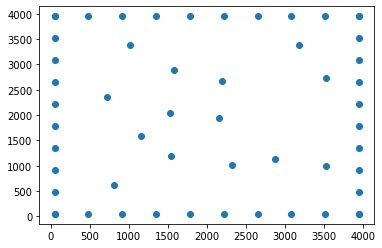

536.5673767089844
1
0 	 45 	 536.5738929748535	1 	 39 	 536.6062069702149	2 	 40 	 536.6062069702149
3 	 47 	 536.6471424865723	4 	 41 	 536.6985040283203	5 	 36 	 536.731051940918
6 	 43 	 536.8442010498047	7 	 38 	 536.8581024169922	8 	 49 	 536.8581024169922
9 	 44 	 536.9981185913086	10 	 37 	 536.9981185913086	11 	 42 	 536.9981185913086
12 	 46 	 536.9981185913086	13 	 48 	 537.1396385192871	

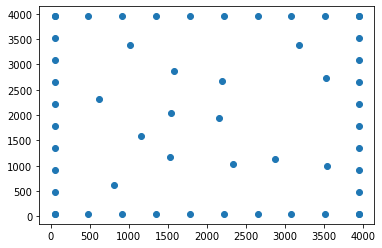

537.1396385192871
2
0 	 45 	 537.1396385192871	1 	 36 	 537.1621279907226	2 	 42 	 537.1621279907226
3 	 41 	 537.2503147888184	4 	 49 	 537.2503147888184	5 	 48 	 537.2503147888184
6 	 37 	 537.2503147888184	7 	 44 	 537.2503147888184	8 	 38 	 537.251517791748
9 	 43 	 537.2856028747559	10 	 40 	 537.2856028747559	11 	 39 	 537.2856028747559
12 	 46 	 537.2856028747559	13 	 47 	 537.2856028747559	

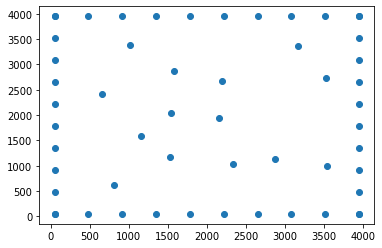

537.2856028747559
3
0 	 39 	 537.2856028747559	1 	 45 	 537.2856028747559	2 	 40 	 537.2856028747559
3 	 38 	 537.2856028747559	4 	 43 	 537.2856028747559	5 	 36 	 537.3088275146484
6 	 49 	 537.3089277648926	7 	 41 	 537.3089277648926	8 	 44 	 537.3089277648926
9 	 37 	 537.3089277648926	10 	 42 	 537.3089277648926	11 	 47 	 537.3089277648926
12 	 48 	 537.3089277648926	13 	 46 	 537.3089277648926	

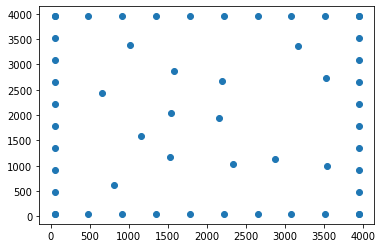

537.3089277648926
4
0 	 45 	 537.3089277648926	1 	 36 	 537.3089277648926	2 	 39 	 537.3089277648926
3 	 46 	 537.3089277648926	4 	 42 	 537.3089277648926	5 	 44 	 537.3089277648926
6 	 49 	 537.3598883056641	7 	 38 	 537.3598883056641	8 	 40 	 537.3598883056641
9 	 41 	 537.3598883056641	10 	 47 	 537.3598883056641	11 	 48 	 537.3598883056641
12 	 37 	 537.3598883056641	13 	 43 	 537.3598883056641	

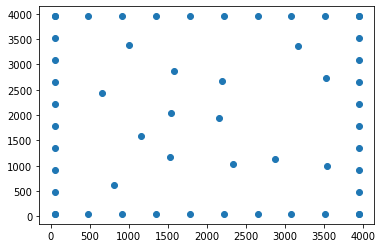

537.3598883056641
5
0 	 40 	 537.3598883056641	1 	 49 	 537.3598883056641	2 	 38 	 537.3598883056641
3 	 45 	 537.3598883056641	4 	 43 	 537.3598883056641	5 	 46 	 537.3598883056641
6 	 47 	 537.3598883056641	8 	 41 	 537.3598883056641
9 	 44 	 537.3598883056641	10 	 36 	 537.3598883056641	11 	 39 	 537.3598883056641
12 	 42 	 537.3598883056641	13 	 37 	 537.3598883056641	

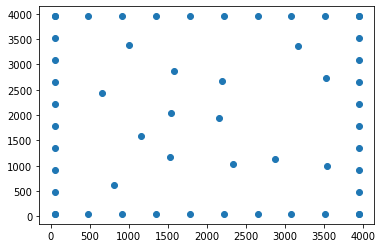

537.3598883056641
algorithm saturated


In [58]:
'''try moving each of the turbines'''
last_AEP = AEP_simp(np.array(locs1))    
for _ in range(15):
    # order = np.arange(50)
    order = np.arange(36,50)
    np.random.shuffle(order)
    print(_)
    
    for ind,index in enumerate(order):
        maxAEP,x,y = move(locs1,index,3500,100,72)
        #maxAEP,x,y = move_sqr(locs1,index,4000,50)
        print(ind,'\t',index,'\t',maxAEP,end = ['\t','\n'][ind%3==2])
        locs1[index] = x,y
    curr_AEP = AEP_simp(np.array(locs1))
    plot_turbine_locations(locs1);print(curr_AEP);#to_csv(locs1,'iter_turb1.csv')

    if last_AEP == curr_AEP:
        print('algorithm saturated')
        break
    last_AEP = curr_AEP
    

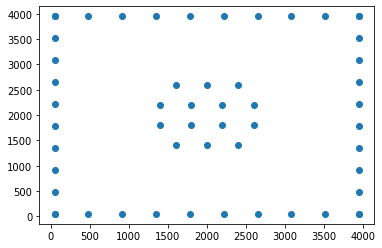

523.0351977539062


In [57]:
plot_turbine_locations(locs1);print(AEP_simp(np.array(locs1)));#to_csv(locs1,'iter_turb1.csv')

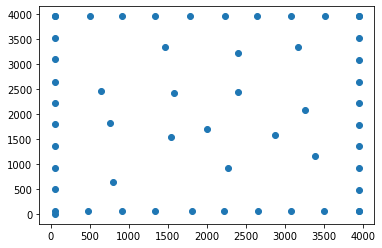

537.8450326538086


In [ ]:
plot_turbine_locations(locs1);print(AEP_simp(np.array(locs1)));#to_csv(locs1,'iter_turb1.csv')

In [145]:
# to_csv(locs1,'/content/iter_turb_oct12_samples_1.csv')
to_csv(locs2,'/content/iter_turb_oct12_grid_2.csv')
# to_csv(locs1,'/content/iter_turb_oct10_genetic_samples_2.1.csv')
# to_csv(locs1,'/content/iter_turb_xo_2.csv')
# to_csv(locs1,'/content/iter_turb_xo_3.csv')
# to_csv(locs1,'/content/iter_turb2.csv')
# to_csv(locs1,'/content/iter_turb3.csv')

In [136]:
def move_over_the_grid(turbine_coords,index,X,Y):
    '''move a selected turbine to different positions and
    return the max AEP position'''
    # tx,ty = turbine_coords[index]
    Z = np.zeros((X.shape[0],Y.shape[1]))
    ind = -1
    for ix, x in enumerate(X.ravel()):
        for iy, y in enumerate(Y.ravel()):
            point = [x, y]
            if check_inc_violation(turbine_coords[:index],point) or \
                check_inc_violation(turbine_coords[index+1:],point):
                Z[ix,iy] = -1e7
                continue
            turbine_coords[index][0], turbine_coords[index][1] = point
            Z[ix,iy] = AEP_simp(turbine_coords)
        
    return Z

In [153]:
locs2 = locs1.copy()

In [131]:
x,y = np.ogrid[50:3950:25j,50:3950:25j]
for index in range(49,50):
    # z = move_over_the_grid(locs2,index,x,y)
    ii0,ii1 = ii = divmod(z.argmax(),z.shape[0])
    print(x[ii0,0], y[0,ii1], z[ii], z.max())
    temp = locs2.copy()
    temp[index][0], temp[index][1] = x[ii0,0], y[0,ii1]
    print(AEP_simp(temp))

1512.5 1187.5 536.531487121582 536.531487121582
536.531487121582


36 536.5374353027344


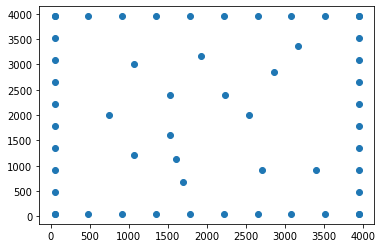

37 536.600592956543


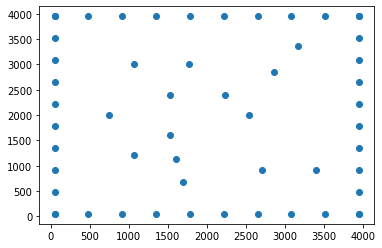

38 536.6844021606445


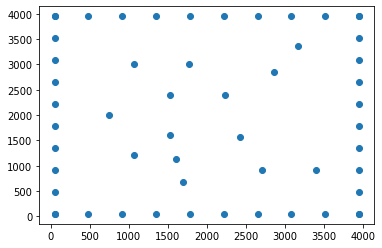

39 536.7675430297852


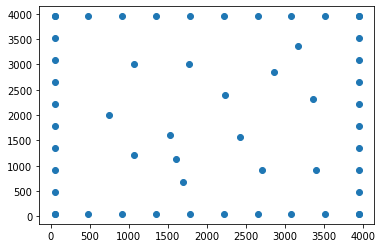

40 536.7675430297852


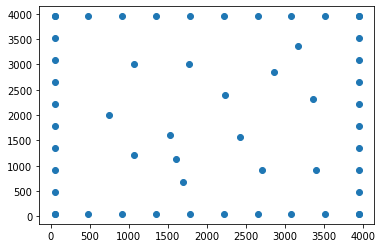

41 536.7675430297852


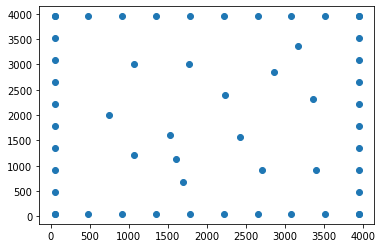

42 536.7675430297852


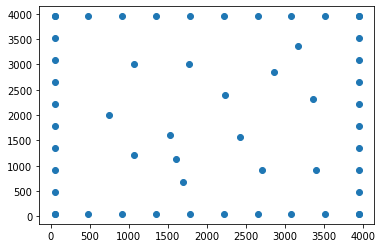

43 536.7796398925781


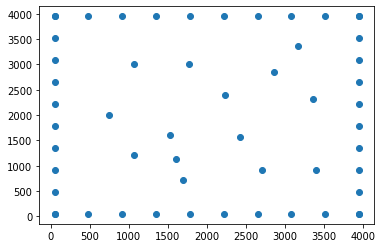

44 536.7997567749023


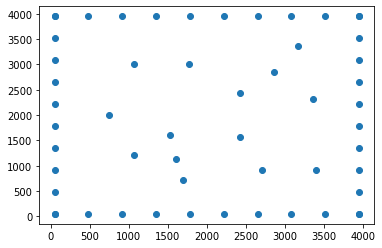

In [ ]:
step = 100 + 1 
x,y = np.ogrid[50:3950:1j*step,50:3950:1j*step]
for index in range(36,50):
    z = move_over_the_grid(locs2,index,x,y)
    ii0,ii1 = ii = divmod(z.argmax(),z.shape[0])
    locs2[index][0], locs2[index][1] = x[ii0,0], y[0,ii1]
    print(index,AEP_simp(locs2))
    plot_turbine_locations(locs2)

In [ ]:
 to_csv(locs2,'/content/iter_turb_oct12_grid_x_3.csv')

In [130]:
,ii0,ii1 = ii = divmod(z.argmax(),z.shape[0])
print(x[ii0,0], y[0,ii1], z[ii], z.max())

1512.5 1187.5 536.531487121582 536.531487121582


In [117]:
x,y = np.ogrid[50:3950:25j,50:3950:25j]
z = move_over_the_grid(locs1,48,x,y)
# x.shape,y.shape

536.3166174316407


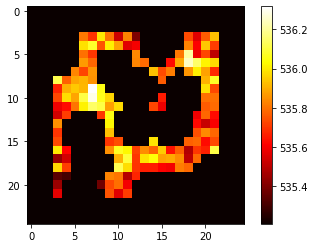

In [118]:
z1 = z.copy()
z1[z1 == 530] = (z[z!=530].min() -0.1)
plt.imshow(z1,cmap='hot');plt.colorbar();print(z.max())

In [121]:
zmaxi = z.argmax()
z.max(), z[divmod(zmaxi,z.shape[0])]

(536.3166174316407, 536.3166174316407)

In [113]:
x,y = np.ogrid[50:3950:50j,50:3950:50j]
z = move_over_the_grid(locs1,49,x,y)
# x.shape,y.shape

537.2359455871582


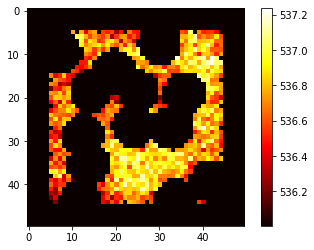

In [114]:
z1 = z.copy()
z1[z1 == 530] = (z[z!=530].min() -0.1)
plt.imshow(z1,cmap='hot');plt.colorbar();print(z.max())

In [107]:
x,y = np.ogrid[50:3950:100j,50:3950:100j]
z = move_over_the_grid(locs1,49,x,y)
# x.shape,y.shape

537.3344915771485


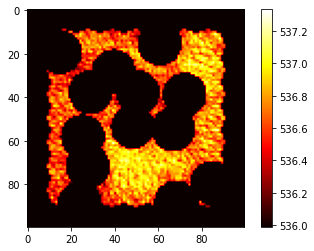

In [112]:
z1 = z.copy()
z1[z1 == 530] = (z[z!=530].min() -0.1)
plt.imshow(z1,cmap='hot');plt.colorbar();print(z.max())

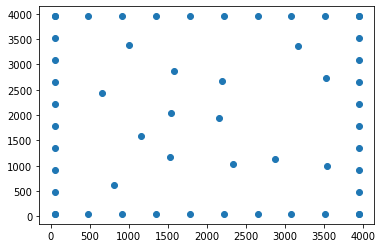

In [64]:
plot_turbine_locations(locs1);#print(AEP_simp(np.array(locs1)));

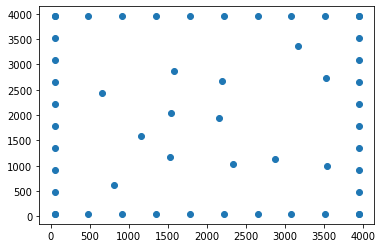

In [68]:
plot_turbine_locations(locs1[:-1]);

IndexError: ignored

In [ ]:
plt.

In [ ]:
'''reducting the 4k x 4k grid into a 9x9 grid'''
n1   = int(  np.ceil( (4000 - 2*(50+400))/400)  )
x    = np.linspace(450,4000-450,n1)
locs_64 = np.array([[i,j] for i in x for j in x])

In [ ]:
def generate_gene(x=14,y=64):
    order = np.arange(y)
    np.random.shuffle(order)
    gene  = np.zeros(y,dtype=np.int8)
    gene[order[:x]] = 1
    return gene

def gene_to_locs(gene):
    return np.vstack([locs_36,locs_64.copy()[gene==1]])

In [ ]:
generate_gene()

array([0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
      dtype=int8)

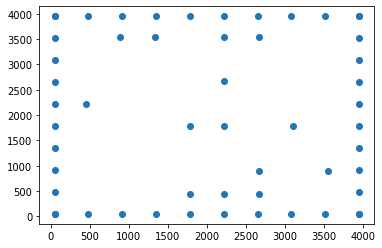

529.1408386230469


In [ ]:
locs_2 = gene_to_locs(generate_gene())
plot_turbine_locations(locs_2);print(AEP_simp(np.array(locs_2)));#to_csv(locs1,'iter_turb1.csv')

In [ ]:
dist = []
for i in range(1000):
    locs_2 = gene_to_locs(generate_gene())
    AEP = AEP_simp(locs_2)
    dist.append(AEP)

In [ ]:
dist = np.array(dist)
print(dist.min(),dist.mean(),dist.var(),dist.max())

527.5476617431641 530.5446488401794 0.711522298091841 532.8471235656739


(array([  2.,   0.,  31.,   0., 226.,   0., 458.,   0., 236.,  47.]),
 array([527. , 527.5, 528. , 528.5, 529. , 529.5, 530. , 530.5, 531. ,
        531.5, 532. ]),
 <a list of 10 Patch objects>)

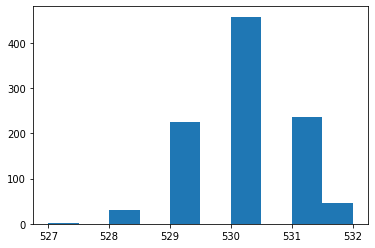

In [ ]:
dist_int = [int(i) for i in dist]
plt.hist(dist_int)

In [ ]:
def mix_genes_uni(gene1,gene2):
    l = [[] for i in range(4)]
    for ind,(g1,g2) in enumerate(zip(gene1,gene2)):
        l[g1 + 2*g2].append(ind)
    
    l1, l2  = l[1]   , l[2]
    ll1,ll2 = len(l1), len(l2)
    li1,li2 = ll1 - (ll1>>1), ll2 - (ll2>>1)
    np.random.shuffle(l1)
    np.random.shuffle(l2)
    g1,g2 = gene1.copy(), gene2.copy()
    g1[l1[:li1]] = 0
    g2[l2[:li2]] = 0
    g2[l1[:li1]] = 1
    g1[l2[:li2]] = 1
    return g1,g2

In [ ]:
x,y = 50,2
gen0 = [generate_gene() for i in range(x)]#generation 0
gen_now = gen0
for gen_cnt in range(12):
    # aeps = [[AEP_simp(i),i] for i in map(gene_to_locs,gen_now)]
    for i in range(5*x):
        a,b = -1,-1
        while a==b:
            a,b = np.random.randint(0,x), np.random.randint(0,x)
        gen_now.extend(mix_genes_uni(gen_now[a],gen_now[b]))
    aeps = [[AEP_simp(gene_to_locs(i)),i] for i in gen_now] 
    aeps.sort(reverse=True,key=lambda x:x[0])
    dist = np.array([i[0] for i in aeps])
    print(dist.min(),dist.mean(),dist.var(),dist.max())
    if dist.var()<1e-3:
        break
    gen_now = [i[1] for i in aeps[:(x-y)]] + [generate_gene() for i in range(y)]

528.436547241211 530.708429210316 0.6442084750637813 532.9119186401367
530.061302947998 532.0189397119694 0.3131380600533391 533.7988659667968
529.5592831420898 532.797766968051 0.3471239861569958 534.0950051879882
530.7983427429199 533.4146048975165 0.2446068021620925 534.3011865234375
530.3108258056641 533.7381410522461 0.3353676639987341 534.4858474731445
529.5776623535156 533.9340150221391 0.43576576426459096 534.5234747314453
530.7996125793456 534.153869640281 0.2987493039854752 534.6602494812012
529.577227935791 534.3068677351517 0.4712096726429354 534.7001156616211
528.7961114501953 534.3473987873424 0.7580452612506455 534.8060801696778
529.2480729675293 534.4559045479515 0.6776778186155008 534.8060801696778
530.5526962280273 534.482031584306 0.4961915419341968 534.8060801696778
529.752599029541 534.4197450139826 0.8244168716069262 534.8060801696778


In [ ]:
locsx = [gene_to_locs(i) for i in gen_now]

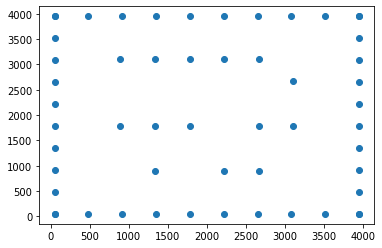

534.8060801696778


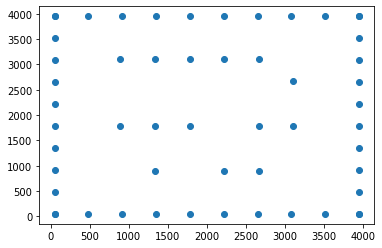

534.8060801696778


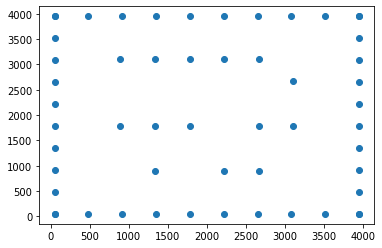

534.8060801696778


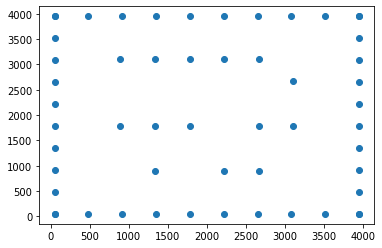

534.8060801696778


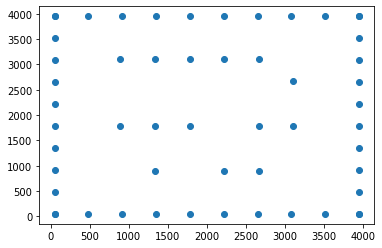

534.8060801696778


In [ ]:
for ind in range(len(locsx[:5])):
    plot_turbine_locations(locsx[ind]);print(AEP_simp(np.array(locsx[ind])));

In [ ]:
def move_turbine_randomly(locs):
    while True:
        index = np.random.randint(0,50)
        angle = np.random.randint(0,360)/360*np.pi
        r     = np.random.randint(0,4000)
        dx,dy = r*np.cos(angle), r*np.sin(angle)
        
        point = [locs[index][0] + dx, locs[index][1] + dy]
        # print(dx,dy)
        if check_inc_violation(locs[:index],point) or \
            check_inc_violation(locs[index+1:],point):
            continue
        locs_copy = locs.copy()
        locs_copy[index][0] += dx
        locs_copy[index][1] += dy
        break
    return locs_copy

In [ ]:
locs_r = move_turbine_randomly(locs0)
print(np.hstack([locs0,locs_r]))

In [ ]:
# locs1 = locsx[0].copy()

In [ ]:
gen_now = [[AEP_simp(locs1),locs1.copy()]]
for gen_cnt in range(10):
    print(gen_cnt)
    nxt_gen = []
    for aep1,locs in gen_now:
        for child in range(3):
            locs1_moved = move_turbine_randomly(locs1)
            nxt_gen.append([AEP_simp(locs1_moved),locs1_moved])
    gen_now.extend(nxt_gen)
    gen_now.sort(key=lambda x:x[0], reverse=True)
    dist = np.array([i[0] for i in gen_now])
    print(dist.min(),dist.mean(),dist.var(),dist.max(),len(dist))
    gen_now = gen_now[:100]  

0
524.1442327880859 524.3235219955444 0.04268344162047872 524.6499952697754 4
1
523.5993392944335 524.2244308948517 0.09590087607677418 524.7105798339844 16
2
523.4994232177735 524.1832097697259 0.10628143849764635 524.8366946411132 64
3
523.2110032653809 524.2133168238402 0.09687846746894929 524.8366946411132 256
4
522.9932263183593 524.2897356582641 0.08602632164309551 524.8366946411132 400
5
523.1159660339356 524.2970487464904 0.11751032009899771 524.9879388427735 400
6
523.1318724060059 524.3425322822571 0.09639551464891806 524.9879388427735 400
7
523.1078791809082 524.3204202529907 0.11939007356616826 524.9879388427735 400
8
523.2590565490723 524.3097299011231 0.12654009278475528 524.9879388427735 400
9
523.259624633789 524.32629324646 0.12484306365381112 524.9879388427735 400


In [ ]:
'''try moving each of the turbines'''
for _ in range(3):
    order = np.arange(50)
    np.random.shuffle(order)
    print(_)
    for ind,index in enumerate(order):
        maxAEP,x,y = move(locs1,index,4000,50)
        #maxAEP,x,y = move_sqr(locs1,index,4000,50)
        print(ind,'\t',index,'\t',maxAEP)
        locs1[index] = x,y
    plot_turbine_locations(locs1);print(AEP_simp(np.array(locs1)));to_csv(locs1,'iter_turb_sep19_v1.csv')

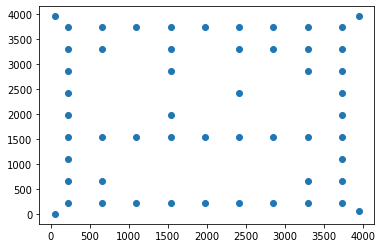

524.458650970459


In [ ]:
 plot_turbine_locations(locs1);print(AEP_simp(np.array(locs1)));#to_csv(locs1,'iter_turb1.csv')